In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import mpltex3

In [2]:
from cycler import cycler

# Create cycler object. Use any styling from above you please
monochrome = (cycler('color', ['k']) *
              cycler('linestyle', ['-', '--', ':', '=.']) *
              cycler('marker', ['^',',', '.']))

# Print examples of output from cycler object. 
# A cycler object, when called, returns a `iter.cycle` object that iterates over items indefinitely
print("number of items in monochrome:", len(monochrome))
for i, item in zip(range(15), monochrome()):
    print(i, item)

number of items in monochrome: 12
0 {'color': 'k', 'linestyle': '-', 'marker': '^'}
1 {'color': 'k', 'linestyle': '-', 'marker': ','}
2 {'color': 'k', 'linestyle': '-', 'marker': '.'}
3 {'color': 'k', 'linestyle': '--', 'marker': '^'}
4 {'color': 'k', 'linestyle': '--', 'marker': ','}
5 {'color': 'k', 'linestyle': '--', 'marker': '.'}
6 {'color': 'k', 'linestyle': ':', 'marker': '^'}
7 {'color': 'k', 'linestyle': ':', 'marker': ','}
8 {'color': 'k', 'linestyle': ':', 'marker': '.'}
9 {'color': 'k', 'linestyle': '=.', 'marker': '^'}
10 {'color': 'k', 'linestyle': '=.', 'marker': ','}
11 {'color': 'k', 'linestyle': '=.', 'marker': '.'}
12 {'color': 'k', 'linestyle': '-', 'marker': '^'}
13 {'color': 'k', 'linestyle': '-', 'marker': ','}
14 {'color': 'k', 'linestyle': '-', 'marker': '.'}


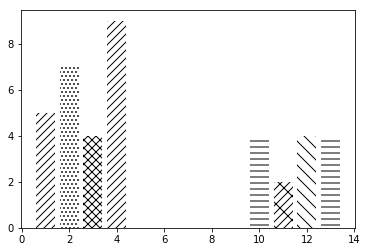

In [3]:
fig, ax = plt.subplots(1,1)

bar_cycle = (cycler('hatch', ['///', '--', '...','\///', 'xxx', '\\\\']) * cycler('color', 'w')*cycler('zorder', [10]))
styles = bar_cycle()

for x in range(1,5):
    ax.bar(x, np.random.randint(2,10), **next(styles))
    ax.bar(x+9, np.random.randint(2,10), **next(styles))

In [132]:
data_folder = './output2_tsne'
# data_folder = './output2_tsne_manual'

In [133]:
line_names = [
    ('NLL(all)', 'q_link', 1),
    ('NLL(ml)', 'q_ml', 1),
    ('NLL(cl)', 'q_cl', 1),
    ('AUC R_NX', 'auc_rnx', -1),
    ('CorrCoef', 'pearsonr', -1),
    ('MDS Stress', 'mds_isotonic', 1),
    ('CCA Stress', 'cca_stress', 1),
    ('Sammon NLM', 'sammon_nlm', 1),
]
needed_columns = list(map(lambda x: x[1], line_names))

In [134]:
def _normalize_0_1(arr):
    return (arr - arr.max()) / -np.ptp(arr)

def _standardize(arr):
    return (arr - arr.mean()) / arr.std()

In [135]:
def load_df(dataset_name, filter_perp = True, lr=100.0, standardize=True, log_scale=False):
    """Load data from pickle file
        The result is a list of object (dict), which then be converted into pandas dataframe
    """
    if dataset_name == "": return None
    
    in_name = '{}/tsne_{}.pkl'.format(data_folder, dataset_name)
    pkl_data = pickle.load(open(in_name, 'rb'))
    embeddeds = pkl_data['results']
    df = pd.DataFrame.from_records(embeddeds, exclude=["embedding"])
    
    if lr is not None:
        df = df[df['learning_rate']==lr]
    if filter_perp:
        df = df[(df['perplexity']<1000) & (df['perplexity']>=1.0)]
    
    for _, col_name, correct_factor in line_names:
        df[col_name] = df[col_name] * correct_factor
    
    if standardize:
        cs = needed_columns
        df[cs] = (df[cs] - df[cs].mean()) / df[cs].std()
    if log_scale:
        df['perplexity'] = np.log(df['perplexity'])

    return df

In [171]:
label_names = {
    'q_link': 'NLL with ML + CL',
    'q_ml': 'NLL with ML only',
    'q_cl': 'NLL with CL only',
    'auc_rnx': 'AUC logRNX',
    'pearsonr': 'Correlation Coefficient',
    'mds_isotonic': 'MDS Stress',
    'cca_stress': 'CCA Stress',
    'sammon_nlm': 'Sammon\'s NLM Stress'
}

def plot_manual(ax, dataset_name, ax_legend=None):
    df = load_df(dataset_name)
    x = df['perplexity']
    x_labels = list(map(int, x.values))
    
    ax.set_title(dataset_name)
    ax.set_xscale('log')
    ax.set_xticks(x.values)
    ax.set_xticklabels(x_labels, rotation=90)
    # not show ticks too much
    for label in ax.get_xticklabels()[2::2]:
        label.set_visible(False)

    if dataset_name == 'COUNTRY2014': # 'BREAST-CANCER95'
        ax.set_xlabel('Perplexity in log-scale')
    
    lines = []
    confs = [
        ('q_link', '-*',    2.0, 0.8),
        ('q_ml', '-',      1.0, 0.8),
        ('q_cl', '-.',      2.0, 0.8),
        
#         ('auc_rnx', '-',    1.5, 1.0),
#         ('pearsonr', '-.',  1.0, 1.0),
#         ('cca_stress', '--',0.6, 0.8),
#         ('mds_isotonic','-',0.6, 0.8),
#         ('sammon_nlm', ':', 0.8, 0.6),
        
#         ('auc_rnx', '-',    1.5, 1.0),
#         ('pearsonr', '--',  1.5, 1.0),        
#         ('cca_stress', '--',1.5, 1.0),
#         ('mds_isotonic','-',1.5, 1.0),
#         ('sammon_nlm', ':',1.5, 1.0)
    ]
    
    for name, style, width, alpha in confs:
        lines += ax.plot(x, df[name], style,  linewidth=width, alpha=alpha)
    
    if ax_legend is not None:
        from matplotlib.legend import Legend
        from matplotlib.patches import Rectangle

        labels = list(map(lambda x: label_names[x[0]], confs))
        # extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        leg = Legend(ax_legend,
                     lines, # + [extra],
                     labels, # + ['(Perplexities in x-axis are shown in log-scale)'],
                     loc='center', frameon=False)
        plt.axis('off')
        ax_legend.add_artist(leg);

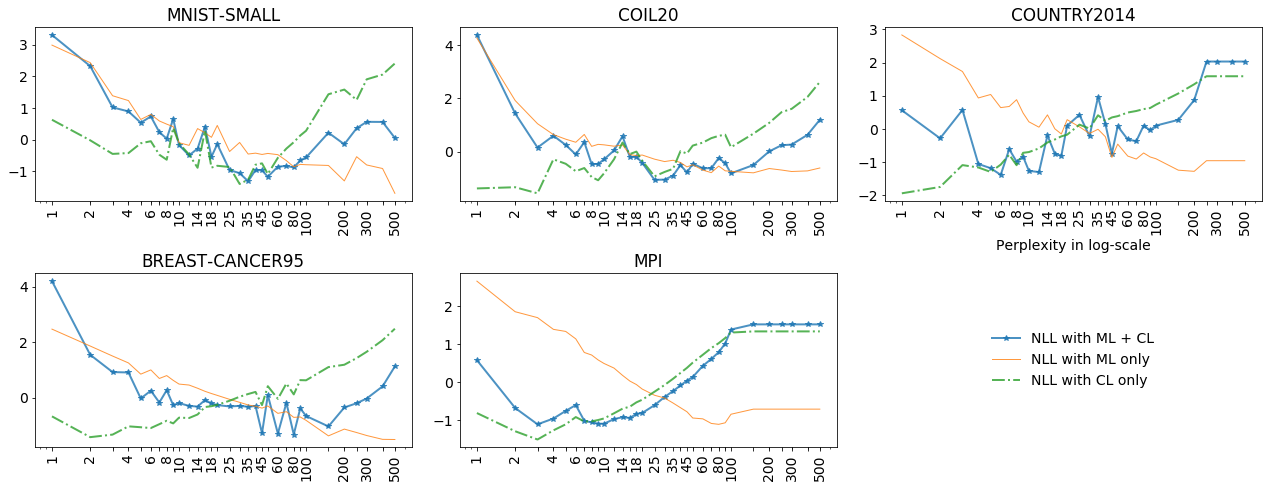

In [172]:
matplotlib.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(2, 3, figsize=(18,7))
plot_manual(axes[0, 0], 'MNIST-SMALL')
plot_manual(axes[0, 1], 'COIL20')
plot_manual(axes[0, 2], 'COUNTRY2014')
plot_manual(axes[1, 0], 'BREAST-CANCER95')
plot_manual(axes[1, 1], 'MPI', axes[1,2])

fig.tight_layout() #(pad=0.1)
# plt.savefig('./plots/nll_stress_metrics_10.pdf')
# plt.savefig('./plots/nll_bounded_metrics_10.pdf')
plt.savefig('./plots/nll_constraints_10.pdf')

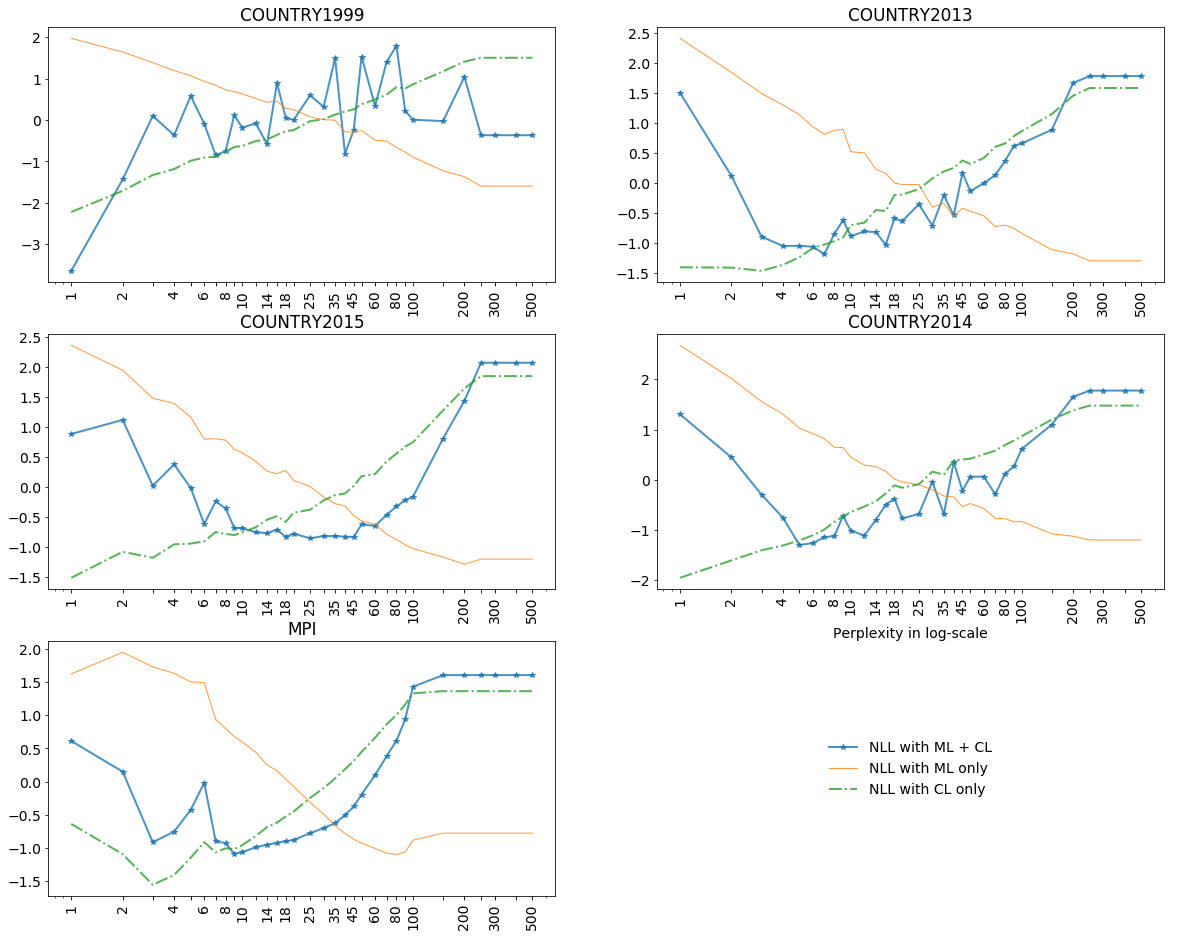

In [123]:
matplotlib.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(3, 2, figsize=(20,16))
# plot_manual(axes[0, 0], 'MNIST-SMALL')
# plot_manual(axes[0, 1], 'COIL20')
plot_manual(axes[0, 0], 'COUNTRY1999')
plot_manual(axes[0, 1], 'COUNTRY2013')
plot_manual(axes[1, 0], 'COUNTRY2015')
plot_manual(axes[1, 1], 'COUNTRY2014')
# plot_manual(axes[1, 1], 'BREAST-CANCER95')
plot_manual(axes[2, 0], 'MPI', axes[2,1])

# fig.tight_layout() #(pad=0.1)
# plt.savefig('./plots/nll_metrics2-01.pdf')

### Table of cosine distance

In [173]:
# calculate cosine distances for 3 type of links vs 5 metric scores

from scipy.spatial.distance import cosine

def calculate_cosine_dist(dataset_name):
    df = load_df(dataset_name)
    target_lines = ['auc_rnx', 'pearsonr', 'cca_stress', 'mds_isotonic', 'sammon_nlm']
    res = {target_line: () for target_line in target_lines}
    for target_line in target_lines:
        cosine_all = cosine(df['q_link'], df[target_line])
        cosine_ml = cosine(df['q_ml'], df[target_line])
        cosine_cl = cosine(df['q_cl'], df[target_line])
        res[target_line] = (cosine_all, cosine_ml, cosine_cl)
        
    return res

In [126]:
selected_datasets = [
#     'MNIST-SMALL',
#     'COIL20',
#     'COUNTRY1999',
    'COUNTRY2014',
#     'COUNTRY2015',
#     'BREAST-CANCER95', # '\\vtop[ \\hbox[ \\strut BREAST ] \\hbox[ \\strut -CANCER95 ] ]'
    'MPI',
    'DIABETES'
]

name0 = """{name} & \\vtop[ \\hbox[ \\strut \\verb|ML + CL| ] \\hbox[ \\strut \\verb|ML only| ] \\hbox[ \\strut \\verb|CL only| ] ] &"""

cell0 = " ({:.3f}, {:.3f}, {:.3f}) &"
cell = "\\vtop[ \\hbox[ \\strut {qall}]  \\hbox[ \\strut {qml}]  \\hbox[ \\strut {qcl}] ] &"

wrap0 = "{value:.3f}"
wrap1 = "\\textbf[{value:.3f}]"

for dataset_name in selected_datasets:
    res = calculate_cosine_dist(dataset_name)
    row = name0 .format(name=dataset_name)
    
    for k, v in res.items():
        v_all, v_ml, v_cl = v
        v_min = min(min(v_all, v_ml), v_cl)
        qall = (wrap1 if v_all == v_min else wrap0).format(value=v_all)
        qml = (wrap1 if v_ml == v_min else wrap0).format(value=v_ml)
        qcl = (wrap1 if v_cl == v_min else wrap0).format(value=v_cl)
        # print(qall, qml, qcl)
        row += cell.format(qall=qall, qml=qml, qcl=qcl)
    row = "{}\\\\".format(row[:-1])
    row = row.replace("[", "{")
    row = row.replace("]", "}")
    
    print(row)
    print("\hline")
    print()

COUNTRY1999 & \vtop{ \hbox{ \strut \verb|ML + CL| } \hbox{ \strut \verb|ML only| } \hbox{ \strut \verb|CL only| } } &\vtop{ \hbox{ \strut 1.266}  \hbox{ \strut 1.553}  \hbox{ \strut \textbf{0.490}} } &\vtop{ \hbox{ \strut 1.479}  \hbox{ \strut 1.135}  \hbox{ \strut \textbf{0.912}} } &\vtop{ \hbox{ \strut 1.421}  \hbox{ \strut 1.241}  \hbox{ \strut \textbf{0.805}} } &\vtop{ \hbox{ \strut 1.511}  \hbox{ \strut \textbf{0.952}}  \hbox{ \strut 1.091} } &\vtop{ \hbox{ \strut 1.107}  \hbox{ \strut 1.417}  \hbox{ \strut \textbf{0.607}} } \\
\hline

COUNTRY2014 & \vtop{ \hbox{ \strut \verb|ML + CL| } \hbox{ \strut \verb|ML only| } \hbox{ \strut \verb|CL only| } } &\vtop{ \hbox{ \strut \textbf{0.243}}  \hbox{ \strut 1.327}  \hbox{ \strut 0.528} } &\vtop{ \hbox{ \strut \textbf{0.604}}  \hbox{ \strut 0.854}  \hbox{ \strut 1.023} } &\vtop{ \hbox{ \strut \textbf{0.507}}  \hbox{ \strut 0.995}  \hbox{ \strut 0.879} } &\vtop{ \hbox{ \strut 0.751}  \hbox{ \strut \textbf{0.734}}  \hbox{ \strut 1.163} } &

### Sum of all differences

In [174]:
import collections
from pprint import pprint

target_lines = ['auc_rnx', 'pearsonr', 'cca_stress', 'mds_isotonic', 'sammon_nlm']
base_lines = ['q_link', 'q_ml', 'q_cl']

def cal_sum_diff():
    traces = collections.defaultdict(dict)
    for base_line in base_lines:
        for target_line in target_lines:
            traces[base_line][target_line] = []

    for dataset_name in selected_datasets:
        df = load_df(dataset_name)

        for base_line in base_lines:
            for target_line in target_lines:
                diff = df[base_line] - df[target_line]
                value = np.sum(np.abs(diff))
                traces[base_line][target_line].append(value)
    return dict(traces)

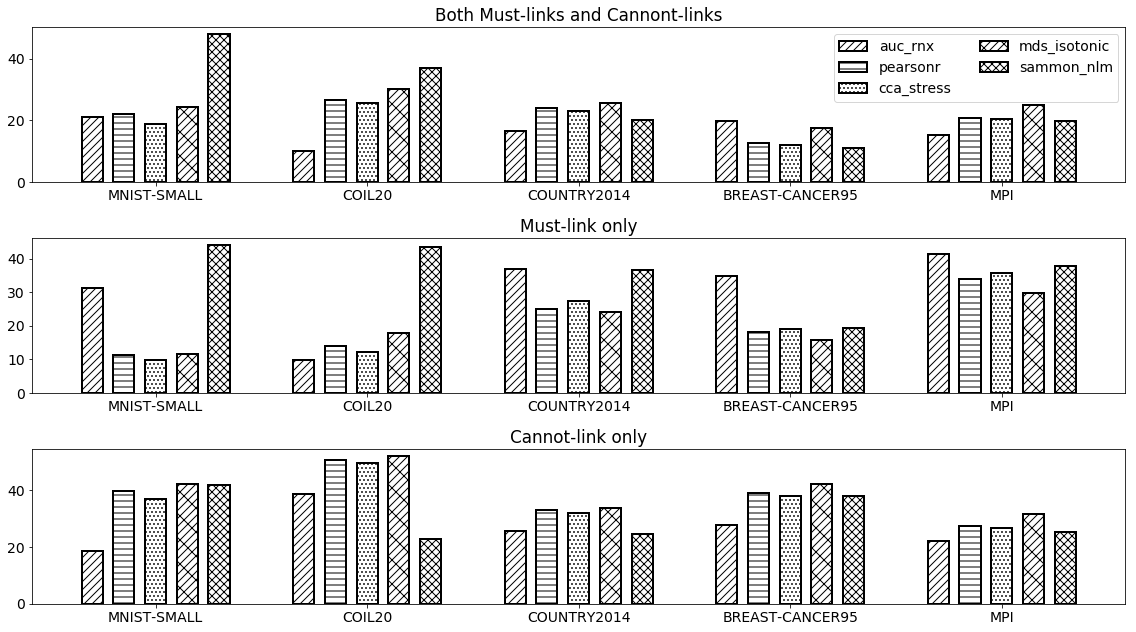

In [180]:
selected_datasets = [
    'MNIST-SMALL',
    'COIL20',
#     'COUNTRY1999',
    'COUNTRY2014',
#     'COUNTRY2015',
    'BREAST-CANCER95', # '\\vtop[ \\hbox[ \\strut BREAST ] \\hbox[ \\strut -CANCER95 ] ]'
    'MPI',
#     'DIABETES'
]

bar_cycle = (cycler('hatch', ['///', '--', '...','\///', 'xxx']) * cycler('color', 'w') * cycler('zorder', [5]))
bar_styles = bar_cycle()

width = 0.1
x_data = np.arange(len(selected_datasets))
    
def _plot_sum_diff(ax, data, title, legend=False):
    for i, (line_name, values) in enumerate(data.items()):
        # print(title, line_name, values)
        ax.bar(x_data + i * 0.15, values, width, **next(bar_styles),
               linewidth=2, edgecolor=['black']*len(x_data), label=line_name)

    ax.set_title(title)
    ax.set_xticks(x_data + 0.3)
    ax.set_xticklabels(selected_datasets)
    
    if legend:
        ax.legend(loc='best', ncol=2)
    
    
def plot_sum_diff():
    res = cal_sum_diff()
    fig, axes = plt.subplots(3, 1, figsize=(16,9))
    _plot_sum_diff(axes[0], res['q_link'], 'Both Must-links and Cannont-links', legend=True)
    _plot_sum_diff(axes[1], res['q_ml'], 'Must-link only')
    _plot_sum_diff(axes[2], res['q_cl'], 'Cannot-link only')
    fig.tight_layout()
    plt.savefig('./plots/sum_diff.pdf')
    # plt.show()
    
plot_sum_diff()

In [193]:
def _best_perp(values, perps):
    idx = np.argmin(values)
    return perps[idx]

In [189]:
df = load_df(dataset_name='MNIST-SMALL')
_best_perp(df['q_link'], df['perplexity'])

35

Loading dataset: MNIST-SMALL
(1797, 64) (1797,) 1797
Loading dataset: COIL20
(1440, 1024) (1440,) 1440
Loading dataset: COUNTRY2014
(246, 140) (246,) 246
Loading dataset: BREAST-CANCER95
(569, 30) (569,) 569
Loading dataset: MPI
(102, 6) (102,) 102
Loading dataset: DIABETES
(768, 8) (768,) 768


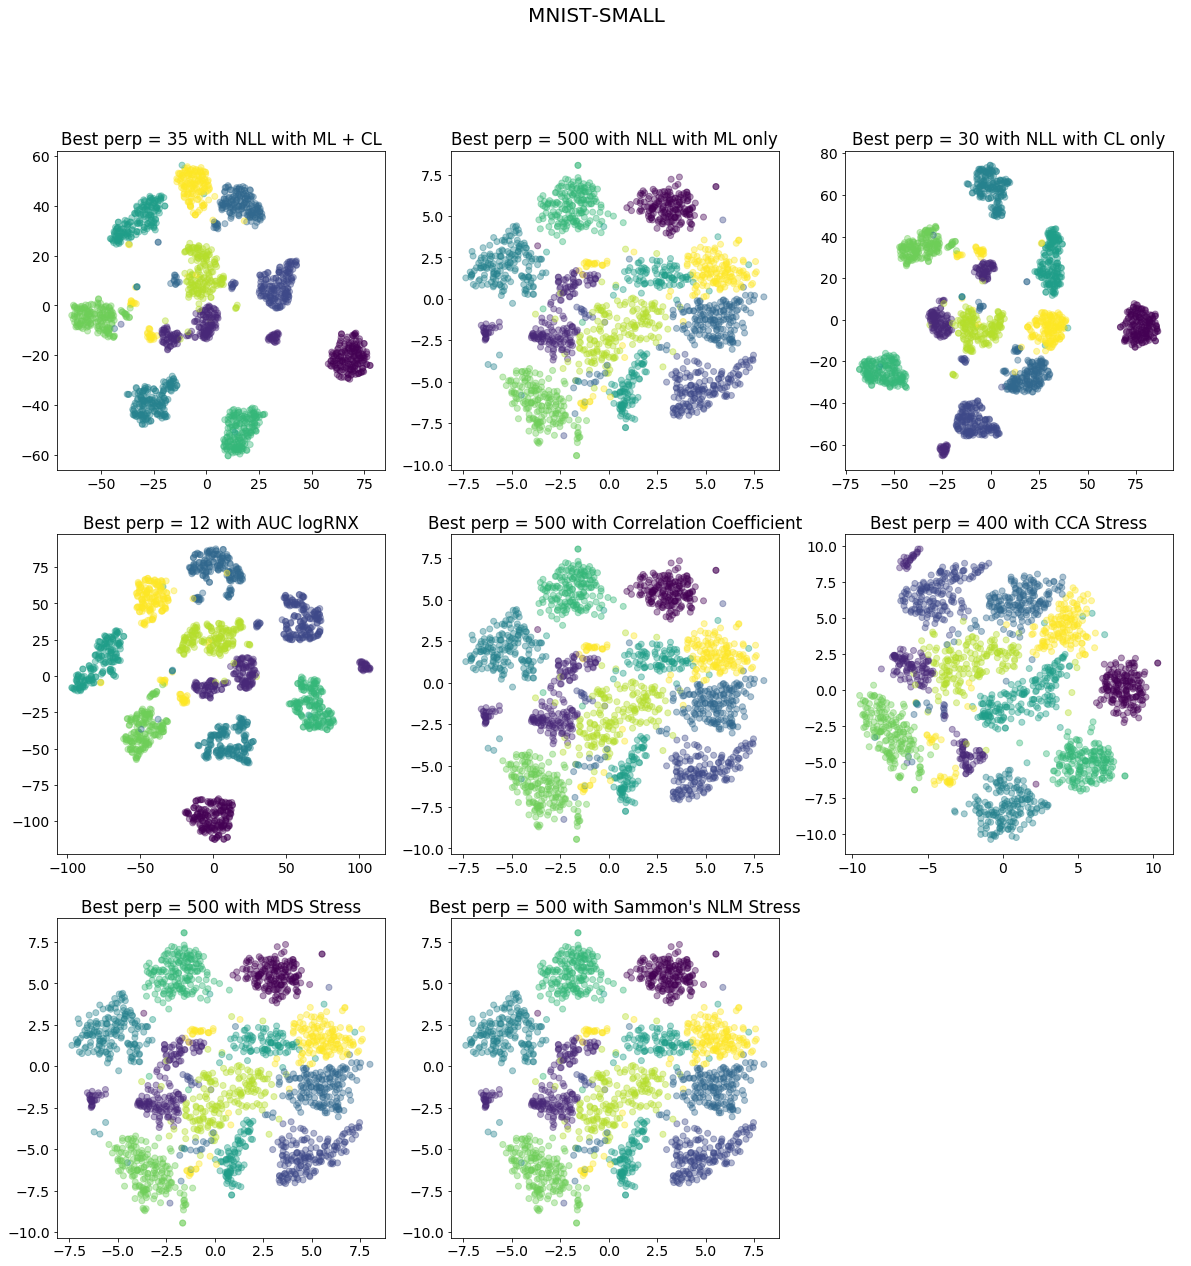

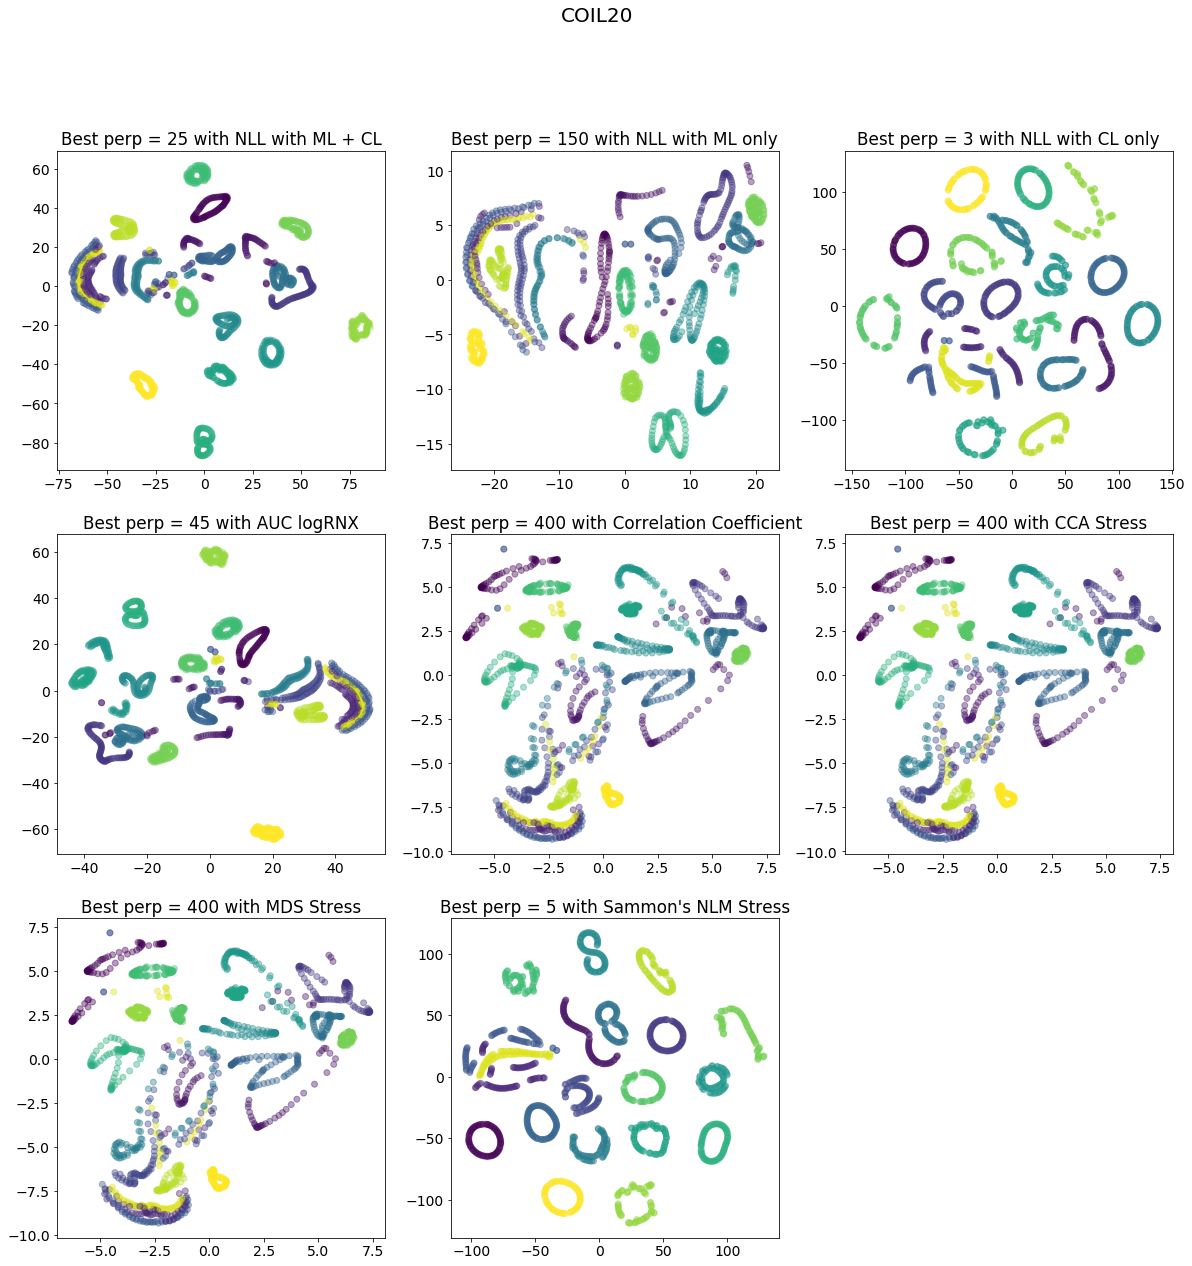

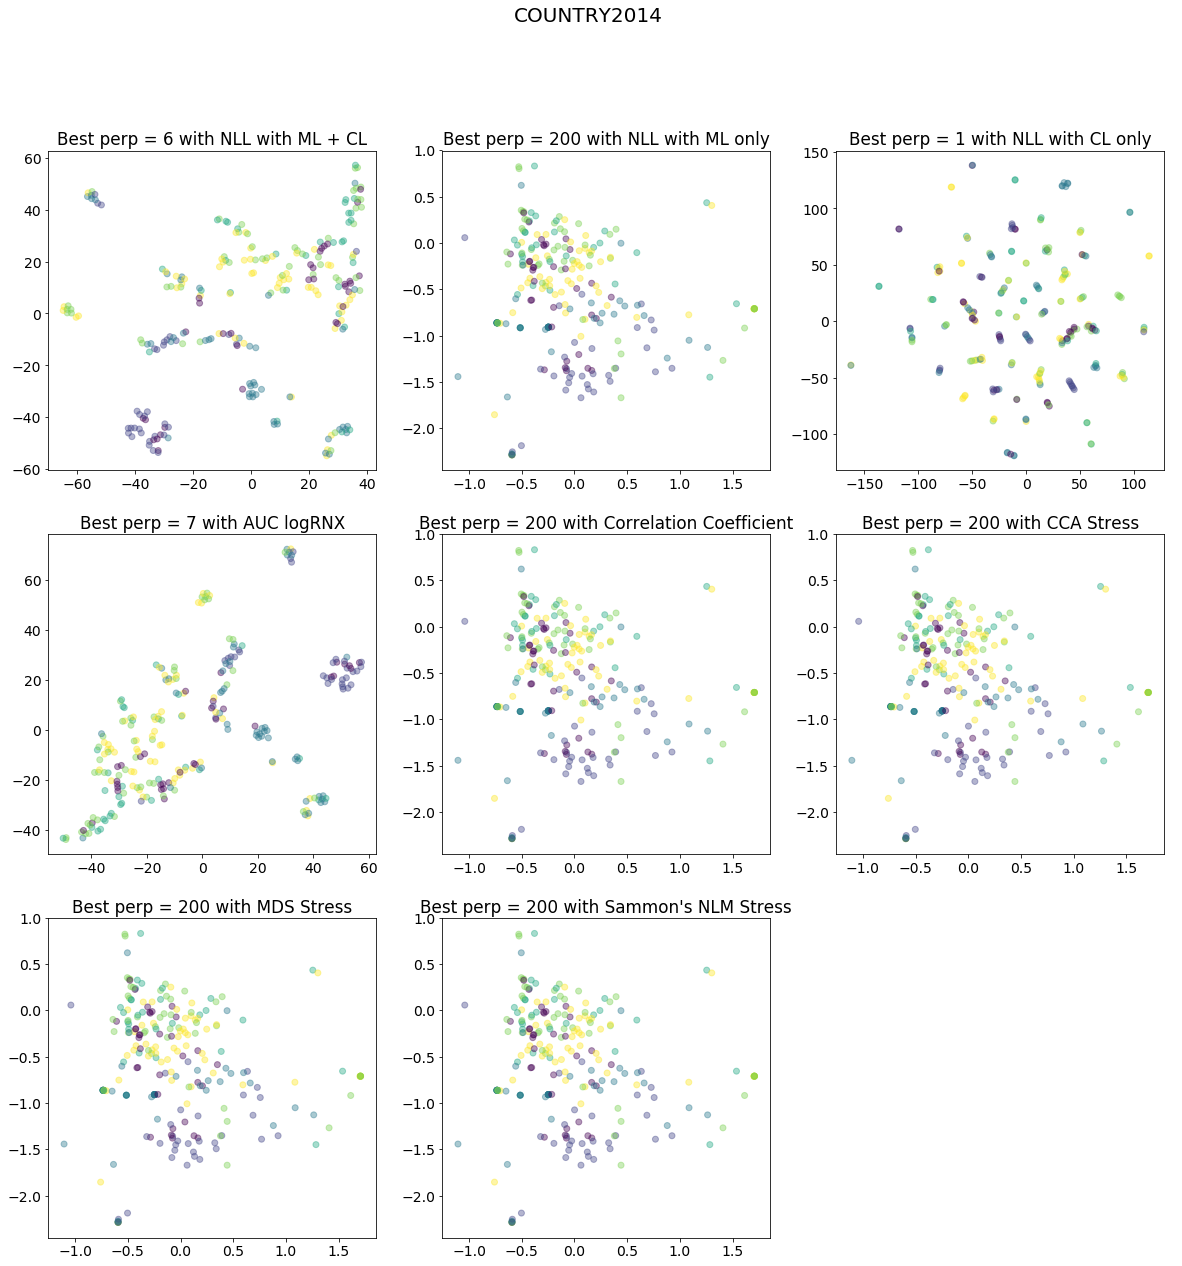

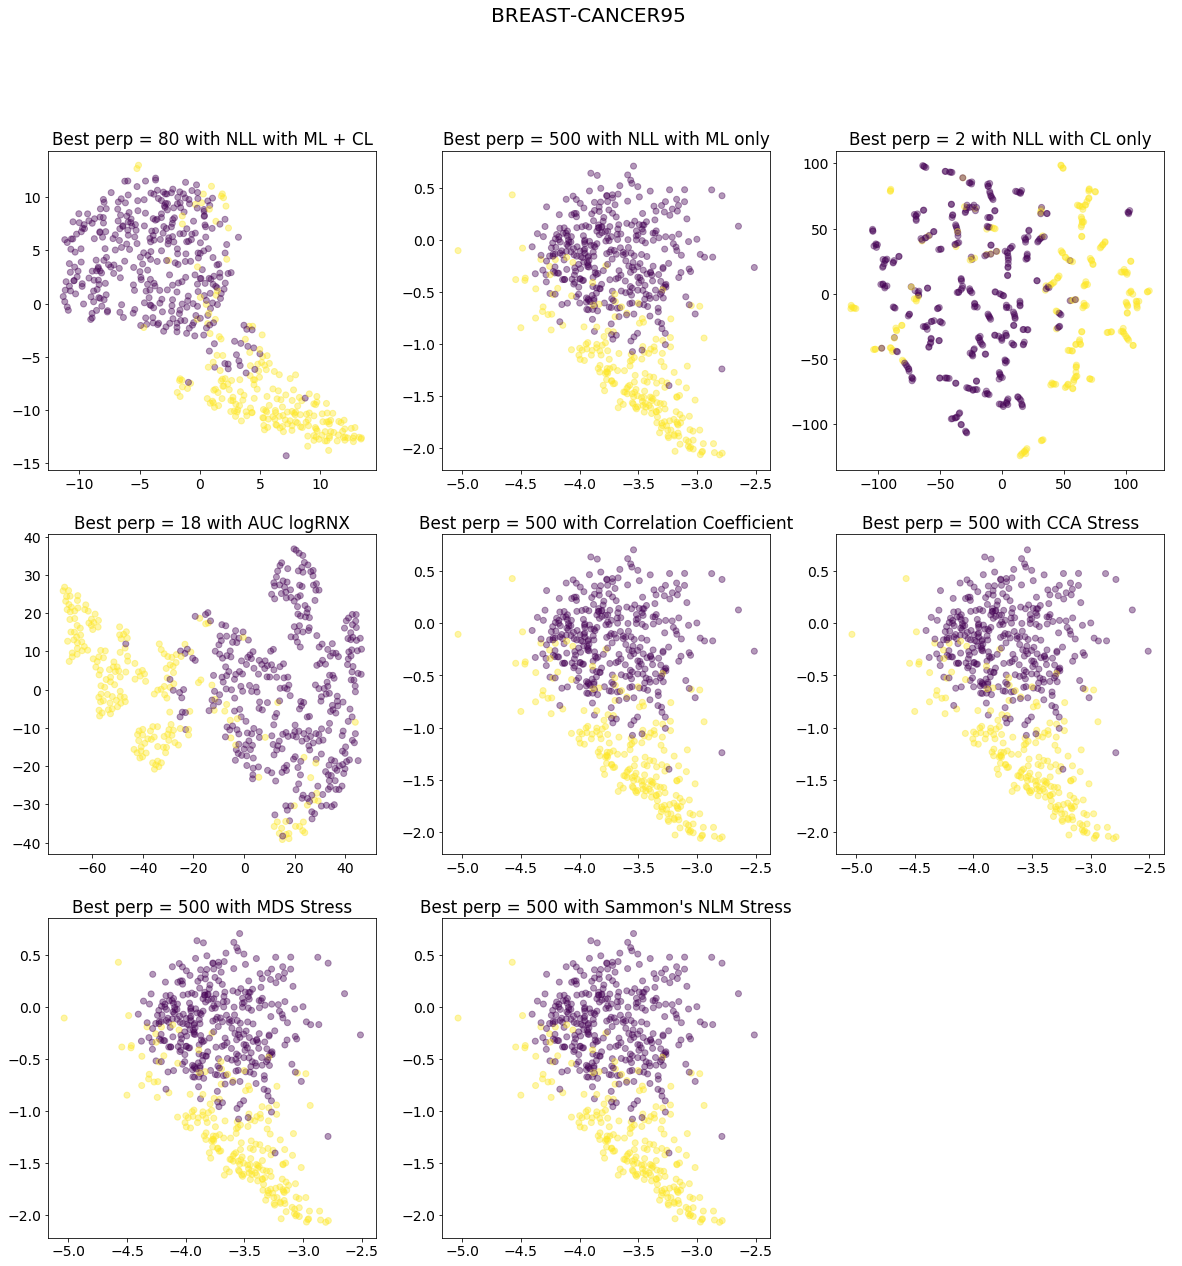

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [222]:
from dataset_utils import load_dataset
import itertools

def plot_by_best_perp(dataset_name):
    # load dataframe with NLL and metric
    df = load_df(dataset_name)
    
    # load original dataset with label for coloring
    X_original, y_original, labels_original = load_dataset(dataset_name)
    print(X_original.shape, y_original.shape, len(labels_original))
    
    # load embedding result for 2d scatter
    in_name = '{}/tsne_{}.pkl'.format(data_folder, dataset_name)
    pkl_data = pickle.load(open(in_name, 'rb'))
    embeddeds = pkl_data['results']
    
    def target(perp, lr=100):
        emb = next((item for item in embeddeds if item['learning_rate'] == lr and item['perplexity'] == perp))
        return emb['embedding']
    
    # find best perp for each 
    line_names = ['q_link', 'q_ml', 'q_cl'] + \
                 ['auc_rnx', 'pearsonr', 'cca_stress', 'mds_isotonic', 'sammon_nlm']

    # setup subplot    
    matplotlib.rcParams.update({'font.size': 14})
    
    fig, axes = plt.subplots(3, 3, figsize=(20,20))
    fig.suptitle(dataset_name, fontsize=20)
    
    def _scater2d(pos, best_perp, title):
        embedding = target(best_perp)
        ax = axes[pos[0], pos[1]]
        ax.scatter(embedding[:,0], embedding[:,1], c=y_original, alpha=0.4)
        ax.set_title(title)
        
    its = itertools.product(range(3), repeat=2)
    
    # get the embedding corresponded to best_perp
    for line_name in line_names:
        best_perp = _best_perp(df[line_name], df['perplexity'])
        pos = next(its)
        ascatter = _scater2d(pos, best_perp,
                  title='Best perp = {} with {}'.format(best_perp, label_names[line_name]))
        
    plt.axis('off')
    # fig.tight_layout() #(pad=0.1)
    plt.savefig('./plots/scatter2d_{}.pdf'.format(dataset_name))
    

selected_datasets = [
    'MNIST-SMALL',
    'COIL20',
#     'COUNTRY1999',
    'COUNTRY2014',
#     'COUNTRY2015',
    'BREAST-CANCER95', # '\\vtop[ \\hbox[ \\strut BREAST ] \\hbox[ \\strut -CANCER95 ] ]'
    'MPI',
    'DIABETES'
]

for dataset_name in selected_datasets:
    plot_by_best_perp(dataset_name)

In [208]:
import itertools

its = itertools.product(range(3), repeat=2)

for _ in range(9):
    print(next(its))

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


In [100]:
# using plotly for notebook in offline mode
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [101]:
def use_plotly(dataset_name):
    df = load_df(dataset_name)
    x_data = np.log(df.perplexity)
    
    confs = [ # http://www.r-graph-gallery.com/125-the-plotlys-symbols/
        ('q_link', dict(shape = 'spline', width = 2.5), dict(symbol=1)),
        ('q_ml', dict(shape = 'spline', width=2.5, dash='solid'), dict(symbol=0)),
        ('q_cl', dict(shape = 'spline', width=2.5, dash='dot'), dict(symbol=4)),
        ('auc_rnx', dict(shape = 'spline', width=1.25, dash='solid'), dict(symbol=25)),
        ('pearsonr', dict(shape = 'spline', width=1.25, dash='dash'), dict(symbol=20)),
        ('cca_stress', dict(shape = 'spline', width=1.25, dash='dot'), dict(symbol=8)),
        ('mds_isotonic', dict(shape = 'spline', width=1.25, dash='dashdot'), dict(symbol=5)),
        ('sammon_nlm', dict(shape = 'spline', width=0.75, dash='dot'), dict(symbol=0)),
    ]
    
    traces = []
    for line_name, line_conf, marker_conf in confs:
        trace = go.Scatter(
            x=x_data,
            y=df[line_name],
            name=line_name,
            line=line_conf,
            marker=marker_conf,
        )
        traces.append(trace)
        # fig.append_trace(trace, 1, 1)
        
    layout = go.Layout(
        title=dataset_name,
        autosize=False,
        showlegend=True,
        xaxis=dict(
            tickvals=x_data,
            ticktext=df.perplexity,
            #title='Perplexity in log-scale'
        ),
        width=800,
#         height=600,
        margin=go.Margin(
            l=30,
            r=0,
            b=30,
            t=30,
            pad=0
        ),
#         yaxis=dict(
#             gridcolor='rgb(255,255,255)',
#             showgrid=True,
#             showline=False,
#             showticklabels=True,
#             tickcolor='rgb(127,127,127)',
#             ticks='outside',
#             zeroline=False
#         ),
    )
    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

In [102]:
dataset_name = 'COUNTRY1999'
use_plotly(dataset_name)

### Find the best perp for each line